数据集定义

In [1]:
import os
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

class ImageDataset(Dataset):
    def __init__(self, txt_file, img_dir, transform=None):
        """
        Args:
            txt_file (string): 包含图片文件名和标签的文本文件路径
            img_dir (string): 存放图片的文件夹路径
            transform (callable, optional): 对样本应用的变换
        """
        self.img_labels = []
        self.img_dir = img_dir
        self.transform = transform

        # 读取txt文件中的图片路径和标签
        with open(txt_file, 'r') as file:
            for line in file:
                image_name, label = line.strip().split()
                self.img_labels.append((image_name, int(label)))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx][0])
        image = Image.open(img_path).convert("RGB")  # 确保图像为RGB格式
        label = self.img_labels[idx][1]

        if self.transform:
            image = self.transform(image)

        return image, label

# 定义图像变换
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

数据集创建

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


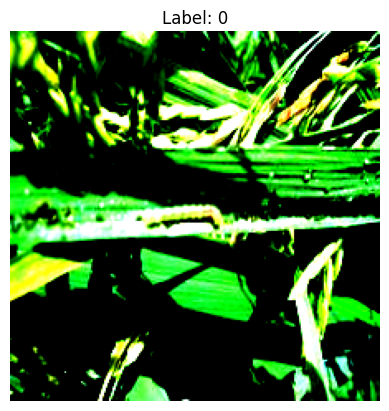

In [2]:
# 创建自定义数据集
train_file = 'ip102_v1.1/train.txt'  # 训练标签文件的路径
val_file = 'ip102_v1.1/val.txt'  # 验证标签文件的路径
test_file = 'ip102_v1.1/test.txt'  # 测试标签文件的路径
img_dir = 'ip102_v1.1/images'       # 图片文件夹的路径

train_set = ImageDataset(txt_file=train_file, img_dir=img_dir, transform=transform)
val_set = ImageDataset(txt_file=val_file, img_dir=img_dir, transform=transform)
test_set = ImageDataset(txt_file=test_file, img_dir=img_dir, transform=transform)

# 使用 DataLoader 加载数据
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)

# 展示图片
plt.imshow(test_set[1][0].permute(1,2,0).numpy())
plt.title(f"Label: 0")
plt.axis('off')
plt.show()

模型创建

In [3]:
import torch
import torch.nn as nn

class Bottleneck(nn.Module):
    expansion = 4  # 每个 Bottleneck 块的输出通道数扩展倍数

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # 1x1 卷积，降维
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3 卷积，特征提取
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1x1 卷积，恢复维度
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        
        # 1x1 卷积1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # 3x3 卷积
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        # 1x1 卷积2
        out = self.conv3(out)
        out = self.bn3(out)
        
        # 如果需要降采样，调整维度
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # 残差连接
        out += identity
        out = self.relu(out)
        
        return out
    

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, dropout_rate=None):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # 初始卷积层和池化层
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # 构建 ResNet 的四个阶段
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.dropout_rate = dropout_rate

        # 添加dropout防止过拟合
        if dropout_rate != None:
            self.dropout = nn.Dropout(dropout_rate)
        
        # 全局平均池化层和全连接层
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        
        # 当需要降采样或通道数不匹配时，进行 downsample
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始层
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 四个残差层
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # 全局池化和全连接层
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # 执行dropout
        if self.dropout_rate != None:
            x = self.dropout(x)
        x = self.fc(x)
        return x

def resnet50(num_classes=102, dropout_rate=None):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, dropout_rate=dropout_rate)
    # return ResNet(Bottleneck, [1, 1, 1, 1], num_classes=num_classes)


模型训练过程定义

In [4]:
def train(model, train_loader, output_dir, criterion, optimizer, num_epochs=20, lr = 0.0001, early_stop=5):
    os.makedirs(output_dir, exist_ok=True)

    # 定义学习率调度器（可选）
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 设置早停
    curr_stop = 0
    curr_loss = float('inf')

    # 保存loss
    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = []
        print(f'Epoch {epoch+1}/{num_epochs}.')

        bar = tqdm(train_loader)
        for images, labels in bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
            bar.desc = f'Training Loss: {loss}'

        train_loss = sum(running_loss) / len(running_loss)
        print(f'Training Loss: {train_loss:.4f}')

        # 验证模型
        model.eval()
        val_loss = []
        with torch.no_grad():
            bar = tqdm(val_loader)
            for images, labels in bar:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss.append(loss.item())
                bar.desc = f'Validation Loss: {loss}'
        val_loss = sum(val_loss) / len(val_loss)
        print(f'Validation Loss: {val_loss:.4f}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # 早停逻辑
        if val_loss < curr_loss:
            curr_loss = val_loss
            curr_stop = 0
            torch.save(model.state_dict(), f'best_model_epoch_{epoch+1}.pth')
        else:
            curr_stop += 1
            if curr_stop >= early_stop:
                break
    # 绘制图形
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses

模型测试过程定义

In [5]:
def test(model, test_loader, criterion, device):
    # 测试模型
    model.eval()
    test_loss = []
    preds = []
    labels = []
    with torch.no_grad():
        bar = tqdm(test_loader)
        for images, label in bar:
            images = images.to(device)
            label = label.to(device)
            outputs = model(images)
            loss = criterion(outputs, label)
            pred = outputs.argmax(dim=1)
            labels += label.tolist()
            preds += pred.tolist()
            test_loss.append(loss.item())
            bar.desc = f'Loss: {loss}'
    test_loss = sum(test_loss) / len(test_loss)
    print(f'Validation Loss: {test_loss:.4f}')

    accuracy = accuracy_score(preds, labels)
    print("Accuracy:")
    print(accuracy)

    # 生成混淆矩阵
    conf_matrix = confusion_matrix(labels, preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # 生成分类报告
    class_report = classification_report(labels, preds)
    print("\nClassification Report:")
    print(class_report)


In [11]:
import torchvision.models as models
def run(name, lr=0.001, dropout_rate=None, weight_decay=0, pretrain=False):

    # 定义损失函数
    criterion = torch.nn.CrossEntropyLoss()

    # 定义模型
    if pretrain:
        model = models.resnet50(pretrained=True)

    else:
        model = resnet50(102, dropout_rate=dropout_rate)
    # 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    print("="*50 + "Training" + "="*50)
    train(model, train_loader, name, criterion, optimizer, num_epochs=20, lr=lr, early_stop=5)
    print("="*50 + "Testing" + "="*50)
    test(model, test_loader, criterion, device='cuda')

    # 刷新显存和内存
    del model        # 删除模型
    del optimizer    # 删除优化器
    del criterion    # 删除损失函数

    # 清除显存
    torch.cuda.empty_cache()

    # 手动垃圾回收
    import gc
    gc.collect()


## ResNet50 Classic

==================================================Training==================================================
Epoch 1.


Loss: 4.466378211975098: 100%|██████████| 705/705 [01:20<00:00,  8.81it/s] 


Epoch 1/20, Loss: 3.7891


Loss: 3.690347194671631: 100%|██████████| 118/118 [00:13<00:00,  8.53it/s] 


Validation Loss: 3.5720
Epoch 2.


Loss: 3.1904451847076416: 100%|██████████| 705/705 [01:19<00:00,  8.91it/s]


Epoch 2/20, Loss: 3.3794


Loss: 4.005685806274414: 100%|██████████| 118/118 [00:13<00:00,  8.46it/s] 


Validation Loss: 3.2710
Epoch 3.


Loss: 3.0838327407836914: 100%|██████████| 705/705 [01:19<00:00,  8.90it/s]


Epoch 3/20, Loss: 3.0598


Loss: 2.757068395614624: 100%|██████████| 118/118 [00:14<00:00,  8.20it/s] 


Validation Loss: 3.0597
Epoch 4.


Loss: 3.495347261428833: 100%|██████████| 705/705 [01:17<00:00,  9.12it/s] 


Epoch 4/20, Loss: 2.7633


Loss: 3.521109104156494: 100%|██████████| 118/118 [00:13<00:00,  8.52it/s] 


Validation Loss: 2.9067
Epoch 5.


Loss: 2.5717556476593018: 100%|██████████| 705/705 [01:24<00:00,  8.31it/s]


Epoch 5/20, Loss: 2.4887


Loss: 2.4342377185821533: 100%|██████████| 118/118 [00:15<00:00,  7.79it/s]


Validation Loss: 2.7874
Epoch 6.


Loss: 2.7539260387420654: 100%|██████████| 705/705 [01:20<00:00,  8.76it/s]


Epoch 6/20, Loss: 2.2336


Loss: 2.591646909713745: 100%|██████████| 118/118 [00:13<00:00,  8.55it/s] 


Validation Loss: 2.7764
Epoch 7.


Loss: 2.004207134246826: 100%|██████████| 705/705 [01:18<00:00,  9.01it/s] 


Epoch 7/20, Loss: 1.9541


Loss: 2.8638620376586914: 100%|██████████| 118/118 [00:14<00:00,  8.08it/s]


Validation Loss: 2.5000
Epoch 8.


Loss: 1.5540777444839478: 100%|██████████| 705/705 [01:14<00:00,  9.42it/s]


Epoch 8/20, Loss: 1.6644


Loss: 2.731834650039673: 100%|██████████| 118/118 [00:13<00:00,  8.43it/s] 


Validation Loss: 2.5450
Epoch 9.


Loss: 1.2990540266036987: 100%|██████████| 705/705 [01:13<00:00,  9.61it/s]


Epoch 9/20, Loss: 1.3535


Loss: 2.657410144805908: 100%|██████████| 118/118 [00:12<00:00,  9.15it/s] 


Validation Loss: 2.9154
Epoch 10.


Loss: 1.2542529106140137: 100%|██████████| 705/705 [01:13<00:00,  9.53it/s]


Epoch 10/20, Loss: 1.0595


Loss: 2.8830647468566895: 100%|██████████| 118/118 [00:13<00:00,  8.91it/s]


Validation Loss: 2.7309
Epoch 11.


Loss: 0.8761519193649292: 100%|██████████| 705/705 [01:12<00:00,  9.68it/s] 


Epoch 11/20, Loss: 0.7860


Loss: 3.0169625282287598: 100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


Validation Loss: 3.0796
Epoch 12.


Loss: 0.7870449423789978: 100%|██████████| 705/705 [01:12<00:00,  9.76it/s] 


Epoch 12/20, Loss: 0.5825


Loss: 2.6369035243988037: 100%|██████████| 118/118 [00:10<00:00, 10.85it/s]


Validation Loss: 3.1697


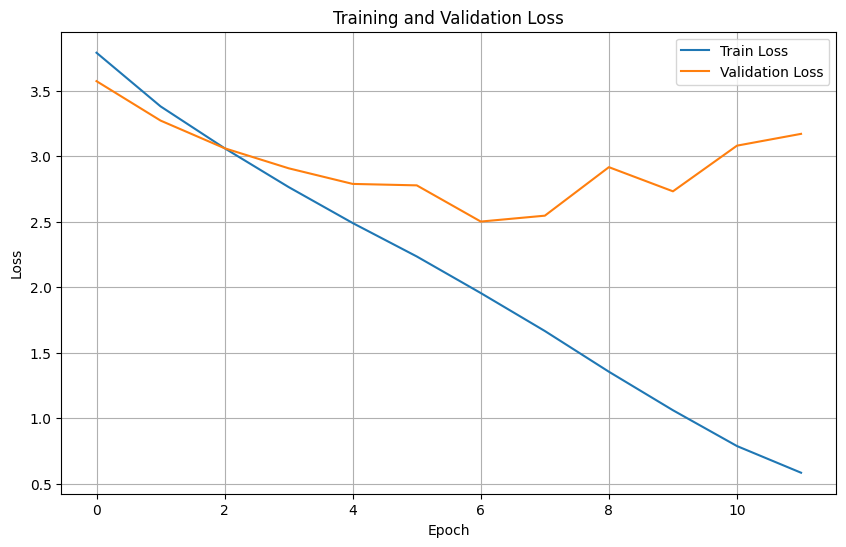

==================================================Testing==================================================


Loss: 3.5316309928894043: 100%|██████████| 354/354 [00:43<00:00,  8.06it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Validation Loss: 3.2207
Accuracy:
0.4051903267164773
Confusion Matrix:
[[ 188   30    1 ...    0    0   16]
 [  13   46    0 ...    0    0   10]
 [   3    2   12 ...    0    0    3]
 ...
 [   0    0    0 ...   40    3    9]
 [   0    0    0 ...    0   39   25]
 [   2    5    3 ...    0    3 1255]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.56      0.58       335
           1       0.18      0.31      0.22       147
           2       0.34      0.15      0.21        79
           3       0.55      0.32      0.40       316
           4       0.49      0.25      0.33       152
           5       0.68      0.50      0.58       152
           6       0.49      0.38      0.43       111
           7       0.22      0.35      0.27       251
           8       0.36      0.23      0.28       268
           9       0.21      0.34      0.26       166
          10       0.39      0.54      0.45       257
          11       0.14     

In [7]:
run('resnet50_classic')

## ResNet50 dropout 0.5

==================================================Training==================================================
Epoch 1.


Loss: 3.7439539432525635: 100%|██████████| 705/705 [01:19<00:00,  8.87it/s]


Epoch 1/20, Loss: 3.9220


Loss: 3.810645580291748: 100%|██████████| 118/118 [00:12<00:00,  9.36it/s] 


Validation Loss: 3.6744
Epoch 2.


Loss: 3.2964928150177: 100%|██████████| 705/705 [01:13<00:00,  9.58it/s]   


Epoch 2/20, Loss: 3.5771


Loss: 3.155128002166748: 100%|██████████| 118/118 [00:12<00:00,  9.72it/s] 


Validation Loss: 3.4646
Epoch 3.


Loss: 3.542022705078125: 100%|██████████| 705/705 [01:13<00:00,  9.62it/s] 


Epoch 3/20, Loss: 3.3272


Loss: 2.5980639457702637: 100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Validation Loss: 3.2792
Epoch 4.


Loss: 3.628154993057251: 100%|██████████| 705/705 [01:12<00:00,  9.78it/s] 


Epoch 4/20, Loss: 3.0940


Loss: 2.9614436626434326: 100%|██████████| 118/118 [00:09<00:00, 12.50it/s]


Validation Loss: 2.9990
Epoch 5.


Loss: 3.0009944438934326: 100%|██████████| 705/705 [01:11<00:00,  9.89it/s]


Epoch 5/20, Loss: 2.8555


Loss: 2.759711980819702: 100%|██████████| 118/118 [00:10<00:00, 11.78it/s] 


Validation Loss: 2.8851
Epoch 6.


Loss: 2.1701443195343018: 100%|██████████| 705/705 [01:11<00:00,  9.91it/s]


Epoch 6/20, Loss: 2.6259


Loss: 2.7814993858337402: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Validation Loss: 2.7785
Epoch 7.


Loss: 2.2620201110839844: 100%|██████████| 705/705 [01:10<00:00,  9.95it/s]


Epoch 7/20, Loss: 2.3769


Loss: 1.629577398300171: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s] 


Validation Loss: 2.6671
Epoch 8.


Loss: 1.939850091934204: 100%|██████████| 705/705 [01:10<00:00,  9.97it/s] 


Epoch 8/20, Loss: 2.1349


Loss: 2.564361333847046: 100%|██████████| 118/118 [00:08<00:00, 13.41it/s] 


Validation Loss: 2.5500
Epoch 9.


Loss: 2.410703420639038: 100%|██████████| 705/705 [01:10<00:00,  9.94it/s] 


Epoch 9/20, Loss: 1.8607


Loss: 2.9194116592407227: 100%|██████████| 118/118 [00:08<00:00, 14.66it/s]


Validation Loss: 2.5656
Epoch 10.


Loss: 1.9184067249298096: 100%|██████████| 705/705 [01:09<00:00, 10.08it/s]


Epoch 10/20, Loss: 1.5674


Loss: 3.1296701431274414: 100%|██████████| 118/118 [00:08<00:00, 14.21it/s]


Validation Loss: 2.6632
Epoch 11.


Loss: 2.0740249156951904: 100%|██████████| 705/705 [01:11<00:00,  9.82it/s]


Epoch 11/20, Loss: 1.2853


Loss: 2.2770566940307617: 100%|██████████| 118/118 [00:08<00:00, 14.36it/s]


Validation Loss: 2.7458
Epoch 12.


Loss: 0.6767060160636902: 100%|██████████| 705/705 [01:11<00:00,  9.83it/s]


Epoch 12/20, Loss: 1.0220


Loss: 3.5516610145568848: 100%|██████████| 118/118 [00:08<00:00, 14.14it/s]


Validation Loss: 2.8811
Epoch 13.


Loss: 0.7215760350227356: 100%|██████████| 705/705 [01:10<00:00, 10.01it/s] 


Epoch 13/20, Loss: 0.8118


Loss: 3.903296947479248: 100%|██████████| 118/118 [00:08<00:00, 14.10it/s] 


Validation Loss: 3.0454


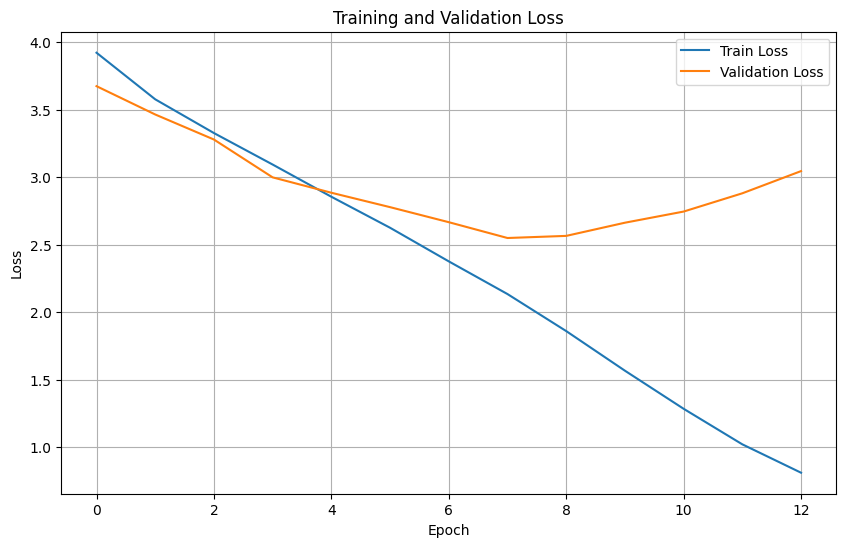

==================================================Testing==================================================


Loss: 2.3500914573669434: 100%|██████████| 354/354 [00:50<00:00,  6.98it/s]


Validation Loss: 3.0493
Accuracy:
0.4137671868782882
Confusion Matrix:
[[ 202    8    0 ...    0    0    5]
 [  23   19    1 ...    0    0    5]
 [   8    0    8 ...    0    1    4]
 ...
 [   0    0    0 ...   35    1    1]
 [   0    0    0 ...    8   48    2]
 [   4    2    2 ...    1    4 1190]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.60      0.54       335
           1       0.23      0.13      0.17       147
           2       0.23      0.10      0.14        79
           3       0.41      0.40      0.40       316
           4       0.66      0.36      0.47       152
           5       0.78      0.41      0.54       152
           6       0.42      0.27      0.33       111
           7       0.29      0.25      0.27       251
           8       0.30      0.24      0.27       268
           9       0.26      0.22      0.24       166
          10       0.31      0.46      0.37       257
          11       0.18     

In [8]:
run('resnet50_dp0.5', dropout_rate=0.5)

## ResNet50 Pretrain

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/pod/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [06:09<00:00, 277kB/s]   


==================================================Training==================================================
Epoch 1/20.


Training Loss: 2.54976224899292: 100%|██████████| 705/705 [01:10<00:00, 10.01it/s]  


Training Loss: 2.9713


Validation Loss: 2.7076687812805176: 100%|██████████| 118/118 [00:11<00:00, 10.14it/s]


Validation Loss: 2.5126
Epoch 2/20.


Training Loss: 1.870332956314087: 100%|██████████| 705/705 [01:10<00:00, 10.07it/s] 


Training Loss: 2.1116


Validation Loss: 1.9058587551116943: 100%|██████████| 118/118 [00:10<00:00, 11.15it/s]


Validation Loss: 2.1419
Epoch 3/20.


Training Loss: 1.4105194807052612: 100%|██████████| 705/705 [01:09<00:00, 10.11it/s]


Training Loss: 1.7187


Validation Loss: 1.8293087482452393: 100%|██████████| 118/118 [00:08<00:00, 13.73it/s]


Validation Loss: 1.9109
Epoch 4/20.


Training Loss: 1.3461447954177856: 100%|██████████| 705/705 [01:10<00:00,  9.99it/s]


Training Loss: 1.4492


Validation Loss: 1.8242065906524658: 100%|██████████| 118/118 [00:08<00:00, 13.19it/s]


Validation Loss: 1.9586
Epoch 5/20.


Training Loss: 1.673262596130371: 100%|██████████| 705/705 [01:10<00:00,  9.98it/s] 


Training Loss: 1.2054


Validation Loss: 2.0759153366088867: 100%|██████████| 118/118 [00:08<00:00, 13.81it/s]


Validation Loss: 1.7998
Epoch 6/20.


Training Loss: 0.9113966822624207: 100%|██████████| 705/705 [01:10<00:00,  9.98it/s]


Training Loss: 0.9915


Validation Loss: 3.2216811180114746: 100%|██████████| 118/118 [00:08<00:00, 14.62it/s]


Validation Loss: 1.8625
Epoch 7/20.


Training Loss: 1.087848424911499: 100%|██████████| 705/705 [01:10<00:00,  9.98it/s]  


Training Loss: 0.7983


Validation Loss: 0.9911917448043823: 100%|██████████| 118/118 [00:08<00:00, 13.96it/s]


Validation Loss: 1.9142
Epoch 8/20.


Training Loss: 0.6962133049964905: 100%|██████████| 705/705 [01:10<00:00,  9.99it/s] 


Training Loss: 0.6261


Validation Loss: 1.6927677392959595: 100%|██████████| 118/118 [00:08<00:00, 14.07it/s]


Validation Loss: 1.8772
Epoch 9/20.


Training Loss: 0.4989818036556244: 100%|██████████| 705/705 [01:10<00:00,  9.98it/s] 


Training Loss: 0.5035


Validation Loss: 2.3328676223754883: 100%|██████████| 118/118 [00:08<00:00, 14.06it/s]


Validation Loss: 2.0685
Epoch 10/20.


Training Loss: 0.5047261714935303: 100%|██████████| 705/705 [01:11<00:00,  9.92it/s] 


Training Loss: 0.3754


Validation Loss: 2.3666322231292725: 100%|██████████| 118/118 [00:08<00:00, 14.15it/s]


Validation Loss: 2.1419


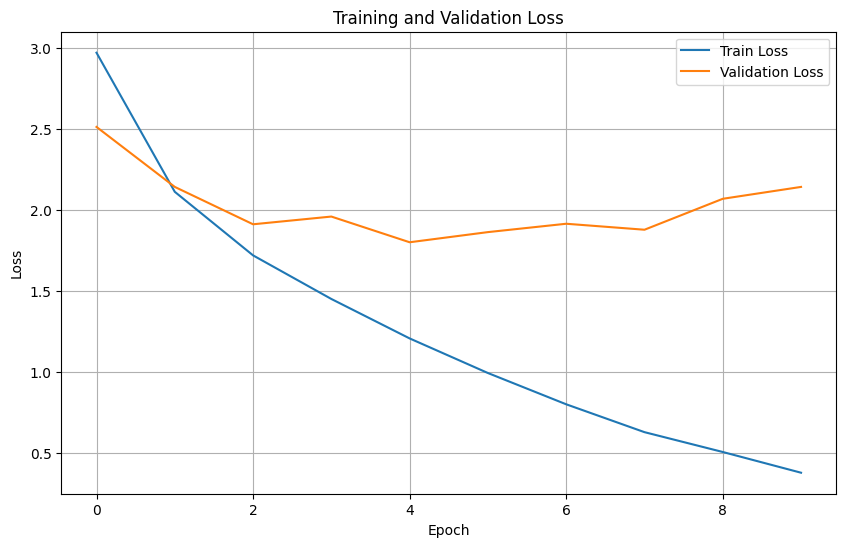

==================================================Testing==================================================


Loss: 1.1092867851257324: 100%|██████████| 354/354 [00:37<00:00,  9.37it/s]


Validation Loss: 2.1569
Accuracy:
0.5407842963879924
Confusion Matrix:
[[ 230    8    0 ...    0    0    4]
 [  29   29    0 ...    0    0    1]
 [   8    0   12 ...    0    0    1]
 ...
 [   0    0    0 ...   59    2    3]
 [   0    1    0 ...    6   64    3]
 [   0    2    1 ...    0    1 1373]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.69      0.62       335
           1       0.42      0.20      0.27       147
           2       0.44      0.15      0.23        79
           3       0.42      0.52      0.47       316
           4       0.57      0.51      0.54       152
           5       0.62      0.62      0.62       152
           6       0.68      0.38      0.49       111
           7       0.63      0.14      0.23       251
           8       0.38      0.41      0.40       268
           9       0.29      0.39      0.33       166
          10       0.77      0.39      0.51       257
          11       0.32     

In [14]:
run('resnet50_pretrain', pretrain=True)